<a href="https://colab.research.google.com/github/alexphil12/Energy-forcasting-UDLA/blob/main/Cnn_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()
import tensorflow as tf
import copy as cp

In [13]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random as rd

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
df = pd.read_csv('/content/df_cov_continu_1_8.txt', index_col=0, parse_dates=True,sep=',')
N=len(list(df.iloc[:,3]))
df_train=df.iloc[0:round(N*0.8),:]
df_test=df.iloc[round(N*0.8):N,:]

In [16]:
scaler = MinMaxScaler()

In [17]:
mesure=["Fecha","Hora"];
mesure.append("Voltaje_(R)_[V]")	
mesure.append("Voltaje_(S)_[V]")	
mesure.append("Voltaje_(T)_[V]")	
mesure.append("Voltaje_(RS)_[V]")	
mesure.append("Voltaje_(ST)_[V]")	
mesure.append("Voltaje_(TR)_[V]")	
mesure.append("Corriente_R_[A]")	
mesure.append("Corriente_S_[A]")	
mesure.append("Corriente_T_[A]")	
mesure.append("Potencia_R_[VA]")	
mesure.append("Potencia_S_[VA]")	
mesure.append("Potencia_T_[VA]")	
mesure.append("Potencia_R_[W]")	
mesure.append("Potencia_S_[W]")	
mesure.append("Potencia_T_[W]")	
mesure.append("Potencia_R_[VAR]")	
mesure.append("Potencia_S_[VAR]")	
mesure.append("Potencia_T_[VAR]")	
mesure.append("Corriente_N_[A]")	
mesure.append("Frecuencia_[Hz]")	
mesure.append("not_sure_1")	
mesure.append("not_sure_2")	
mesure.append("not_sure_3")	
mesure.append("Potencia_3F_[KVA]")	
mesure.append("Potencia_3F_[W]")	
mesure.append("Potencia_3F_[VAR]")	
mesure.append("Factor de Potencia")

In [18]:
RSG_train = df_train[mesure[10]].values
RSG_test=df_test[mesure[10]].values
window_len=2500
long=len(RSG_train)
long_test=len(RSG_test)
Q=long-window_len
Q_test=long_test-window_len
Spectro=np.zeros((1000,11,Q-1))
Spectro_test=np.zeros((1000,11,Q_test-1))
Y=[]
Y_test=[]

In [19]:

Q=long-window_len
scalers=[]
for j in range(Q-1):
  f, t, Sxx = signal.spectrogram(RSG_train[0+j:window_len+j], fs=1/120,nfft=2**13)
  inter=20*np.log10(cp.deepcopy(Sxx[0:1000,:]))
  Spectro[:,:,j]=inter
  Y.append(RSG_train[window_len+j])
  #plt.pcolormesh(t, f[0:1000], Spectro[:,:,j],cmap='jet')
  #plt.ylabel('Frequency [Hz]')
  #plt.xlabel('Time [sec]')
  #plt.show()
for j in range(Q_test-1):
  f, t, Sxx = signal.spectrogram(RSG_test[0+j:window_len+j], fs=1/120,nfft=2**13)
  inter=20*np.log10(cp.deepcopy(Sxx[0:1000,:]))
  Spectro_test[:,:,j]=inter
  Y_test.append(RSG_test[window_len+j])
min=np.min(Spectro)
max=np.max(Spectro)
Spec_scaled=(-1/(min-max))*(Spectro-max)+1
min1=np.min(Spectro_test)
max1=np.max(Spectro_test)
Spec_test_scaled=(-1/(min1-max1))*(Spectro_test-max1)+1
Y = np.array(Y)
Y_test=np.array(Y_test)
scaler=MinMaxScaler()
scaler.fit(Y.reshape(-1,1))  
Y_scaled=scaler.transform(Y.reshape(-1,1))
Y_test_scaled=scaler.transform(Y_test.reshape(-1,1))
  
  

In [20]:
def autocorr_matrix(x,order):
    R = np.zeros((order, order))
    for i in range(0,order):
        for j in range(0,order):
            R[i,j] = autocorrelate(x, abs(i-j))
    return R
def autocorrelate(x,lag):
    return np.correlate(x[0:len(x)-lag],x[lag:len(x)])

In [21]:
taille=30
longueur=len(RSG_train)
longueur_test=len(RSG_test)

In [22]:
autocor=np.zeros((taille,taille,longueur-taille))
autocor_test=np.zeros((taille,taille,longueur_test-taille))

In [23]:
y_auto=[]
y_auto_test=[]
for j in range(longueur-taille):
  sig=RSG_train[j:j+taille]
  Auto_inter=autocorr_matrix(sig,taille)
  autocor[:,:,j]=Auto_inter
  y_auto.append(RSG_train[(j+taille)])
for j in range(longueur_test-taille):
  sig=RSG_test[j:j+taille]
  Auto_inter=autocorr_matrix(sig,taille)
  autocor_test[:,:,j]=Auto_inter
  y_auto_test.append(RSG_train[(j+taille)])
y_auto=np.array(y_auto)
y_auto_test=np.array(y_auto_test)
scaler2=MinMaxScaler()
scaler2_test=MinMaxScaler()
scaler2.fit(y_auto.reshape(-1,1))
scaler2_test.fit(y_auto_test.reshape(-1,1))
y_auto_scaled=scaler2.transform(y_auto.reshape(-1,1))
y_auto_test_scaled=scaler2_test.transform(y_auto_test.reshape(-1,1))
min_a=np.amin(autocor)
max_a=np.amax(autocor)
autocor_scaled=(-1/(min_a-max_a))*(autocor-max_a)+1
min_a_test=np.amin(autocor_test)
max_a_test=np.amax(autocor_test)
autocor_test_scaled=(-1/(min_a_test-max_a_test))*(autocor_test-max_a_test)+1

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
Spec_scaled = np.array(Spec_scaled).reshape(Q-1,1000,11,1)
Spec_test_scaled=np.array(Spec_test_scaled).reshape(Q_test-1,1000,11,1)
print(Spec_scaled.shape)

(9387, 1000, 11, 1)


In [26]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(1000, 11, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [27]:
N=100
#plt.figure(figsize=(7,5))
#plt.pcolormesh(Spectro[0,:,:],cmap='jet')
#plt.colorbar

In [28]:
autocor_scaled=autocor_scaled.reshape(11858,30,30)
autocor_test_scaled=autocor_test_scaled.reshape(2942,30,30)
cnn.compile(optimizer='adam',
              loss='mse')
cnn.fit(Spec_scaled,Y_scaled,epochs=20, verbose=1,batch_size=100,validation_data=(Spec_test_scaled,Y_test_scaled))

Epoch 1/20
94/94 [==============================] - 38s 393ms/step - loss: 0.8120 - val_loss: 0.0666
Epoch 2/20
94/94 [==============================] - 37s 392ms/step - loss: 0.0495 - val_loss: 0.0557
Epoch 3/20
94/94 [==============================] - 37s 392ms/step - loss: 0.0499 - val_loss: 0.0524
Epoch 4/20
94/94 [==============================] - 37s 393ms/step - loss: 0.0496 - val_loss: 0.0546
Epoch 5/20
94/94 [==============================] - 37s 393ms/step - loss: 0.0495 - val_loss: 0.0590
Epoch 6/20
94/94 [==============================] - 38s 405ms/step - loss: 0.0493 - val_loss: 0.0429
Epoch 7/20
94/94 [==============================] - 37s 394ms/step - loss: 0.0498 - val_loss: 0.0477
Epoch 8/20
94/94 [==============================] - 38s 403ms/step - loss: 0.0491 - val_loss: 0.0514
Epoch 9/20
94/94 [==============================] - 37s 394ms/step - loss: 0.0489 - val_loss: 0.0574
Epoch 10/20
94/94 [==============================] - 37s 394ms/step - loss: 0.0485 - val_lo

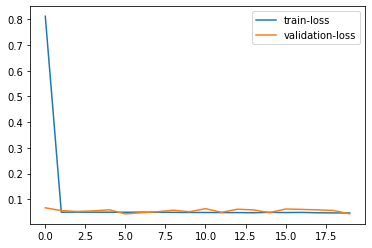

In [29]:
loss_per_epoch = cnn.history.history['loss']
loss_vall=cnn.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.legend()

In [30]:
trainPredict = cnn.predict(Spec_scaled)
Y_true=scaler2.inverse_transform(trainPredict)
RSG_train=RSG_train.tolist()
Y_true=Y_true.tolist()

In [31]:
Q=0
N=9000

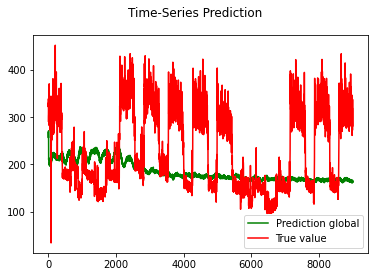

In [32]:
plt.suptitle('Time-Series Prediction')
plt.plot(range(len(Y_true[Q:Q+N])),Y_true[Q:Q+N],label='Prediction global',c="green")
plt.plot(range(len(Y_true[Q:Q+N])),RSG_train[Q:Q+N],label='True value',c="red")
plt.legend()
plt.show()